In [1]:
import numpy as num
from scipy import stats
import matplotlib.pyplot as plt
import math as math
import subprocess
from shutil import copyfile
import os

plt.style.use('seaborn-muted')

In [2]:
def genInstancesNormales(ri=2.0, re=4.0, m=30, n=30, iso=500.0, ninst=2, ti=1500.0, te=50.0, 
                 file="./entradas/entrada1.txt", internalNoise=0.1, externalNoise=0.1):
    f = open(file,'w',encoding = 'utf-8')
    f.write("{0:.1f} {1:.1f} {2:} {3:} {4:.1f} {5:}\n".format(ri, re, m+1, n, iso, ninst))
    
    for insta in range(0, ninst):
        internalTemps = num.full(n, ti)
        internalTemps += num.random.normal(0,internalNoise,n)
        
        externalTemps = num.full(n, te)
        externalTemps += num.random.normal(0,externalNoise,n)    
        
        f.write(' '.join(["{:.2f}".format(elem) for elem in internalTemps]))
        f.write(' ')
        f.write(' '.join(["{:.2f}".format(elem) for elem in externalTemps]))
        f.write('\n')
    f.close()

In [3]:
def genInstancesPeligrosas(ri=2.0, re=7.0, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entrada1.txt", 
                           internalNoise=0.1, externalNoise=0.1, multDeformacion=1500):
    f = open(file,'w',encoding = 'utf-8')
    
    f.write("{0:.1f} {1:.1f} {2:} {3:} {4:.1f} {5:}\n".format(ri, re, m+1, n, iso, ninst))
    
    for insta in range(0, ninst):
        internalTemps = num.full(n, ti)
        internalTemps += num.random.normal(0,internalNoise,n)
        
        externalTemps = num.full(n, te)
        externalTemps += num.random.normal(0,externalNoise,n)
        x = num.linspace(-4,4,n)
        externalTemps += stats.norm.pdf(x, 0, 1)*multDeformacion
        
        f.write(' '.join(["{:.2f}".format(elem) for elem in internalTemps]))
        f.write(' ')
        f.write(' '.join(["{:.2f}".format(elem) for elem in externalTemps]))
        f.write('\n')
    f.close()


In [4]:
def correr(exe='../src/make/tp1', file_in='./entradas/entrada1.txt',
          file_out='./salidas/salida6.txt', method='1'):
    
    subprocess.run('wsl cd /mnt/d/0-Facu/2022-1C-MetNum/tp1/MN2022/tp1/exp; '+exe+' '
                         +file_in+' '+file_out+' '+method)



In [15]:
genInstancesPeligrosas(ri=2.0, re=7.0, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entrada1.txt", 
                           internalNoise=0.1, externalNoise=0.1, multDeformacion=1500)

correr(exe='../src/make/tp1', file_in='./entradas/entrada1.txt',
          file_out='./salidas/salida1.txt', method='1')

temps, isos = getIsotherm(file_in= './entradas/entrada10.txt', file_out='./salidas/salida10.txt', instancias = [0])

In [5]:
def getIsotherm(file_in= './entradas/entrada1.txt', file_out='./salidas/salida1.txt', instancias = [0]):
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = (re - ri)/m
    
    isos = num.empty((len(instancias), n))
    temps = num.empty((len(instancias), m+1, n))
    
    temps_todasLasInstancias= num.loadtxt(file_out).reshape((ninst, m+1, n))
    
    for inst in instancias:

        temp_inst = temps_todasLasInstancias[inst]
        temps[instancias.index(inst)] = temp_inst

        differences = num.abs(temp_inst - iso)
        results = num.empty(n)

        for i in range(0, n):
            column = temp_inst[:,i]
            diffcolumn = differences[:,i]
            closest = diffcolumn.argmin()
            border = True

            if column[closest]<iso:
                if closest > 0:
                    prev = closest - 1
                    pos = closest
                    border = False
                else:
                    iso_radius = ri
            else:
                if closest < m:
                    prev = closest
                    pos = closest + 1
                    border = False
                else:
                    iso_radius = re

            if not border:
                iso_radius = ri + delta_r * (prev + (iso - column[prev])/(column[pos]-column[prev]))

            results[i] = iso_radius
            
        isos[instancias.index(inst)] = results
    
    return temps, isos


In [6]:
def graficar(temps, isos, min_r=2, max_r=7, iso= 500.0):
    (m, n) = temps.shape
    theta = num.linspace(0, 2*num.pi, n)
    
    thetar = num.tile(num.linspace(0, 2*num.pi, n), (m, 1)).transpose()
    r = num.tile(num.linspace(min_r, max_r, m), (n, 1))
    r[:,0] = 0.0
    
    z = temps.transpose()
   
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    dangerBorder = num.full(theta.shape, 1.1*stats.mode(isos)[0][0])
    
    exteriorMode = stats.mode(temps[-1])[0][0]
    interiorMode = stats.mode(temps[0])[0][0]
    
    
    #secondDangerBorder = num.full(theta.shape, min_r + (max_r - min_r)*2.0*((500.0-exteriorMode)/(interiorMode - exteriorMode)))
    secondDangerBorder = num.full(theta.shape, min_r + (max_r - min_r)*1.1*((500.0-interiorMode)/(exteriorMode - interiorMode)))
    print(min_r + (max_r - min_r)*1.5*((500.0-interiorMode)/(exteriorMode - interiorMode)))
    print(1.1*((500.0-interiorMode)/(exteriorMode - interiorMode)))
    
    
    #\frac{max(isoterma_{500^\circ C}(\theta)) - r_i}{r_e - r_i} > 
    #1.5 \times \frac{500^\circ C - moda(T_e(\theta))}{T_i - moda(T_e(\theta))}
    
    fig.set_figwidth(15)
    fig.set_figheight(10)
    ax.plot(theta, isos, 'k--', label='Isotermia '+ str(iso))
    ax.plot(theta, dangerBorder, 'rx', label='1.1 x moda(isoterma)')
    ax.plot(theta, secondDangerBorder, 'mx', label='segunda Frontera')
    grafico = ax.pcolor(thetar, r, z, cmap='jet')
    ax.set_rticks([x for x in range(1, math.ceil(max_r), )])
    ax.grid(True)
    ax.set_rmax(max_r)
    ax.legend(loc='upper left')

    fig.colorbar(grafico)
    ax.set_title('Alto horno - Isotermia: ' + str(iso))

    plt.show()


In [7]:
def generarGraficos(exe='../src/build/tp1',
                    file_in='./entradas/entrada1.txt', 
                    file_out='./salidas/salida1.txt', 
                    method='1'):
    
    correr(exe, file_in, file_out, method)

    temps, isos = getIsotherm(file_in, file_out, instancias=[0])
    
    f = open(file_in,'r',encoding = 'utf-8')
    params = num.matrix(f.readline())
    ri = params[0,0]
    re = params[0,1]
    iso = params[0,4]
    f.close()
    
    graficar(temps[0], isos[0], min_r=ri, max_r=re, iso=iso)
    
    return temps, isos
    

7.172458381032509
0.7586272292181014


<ipython-input-6-f095a59c0710>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


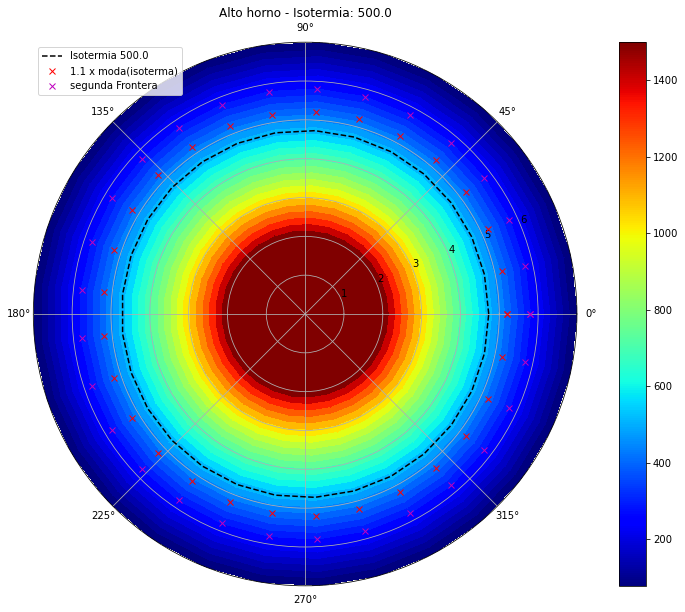

In [8]:
genInstancesNormales(ri=2, re=7, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entradaNormal.txt', 
                        internalNoise=0.1, externalNoise=0.1)
tempsSafe, isosSafe = generarGraficos(exe='../src/build/tp1',file_in='./entradas/entradaNormal.txt',
                                      file_out='./salidas/salidaNormal.txt', method='1')

8.818144629789554
0.9999945457024682


<ipython-input-60-f095a59c0710>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


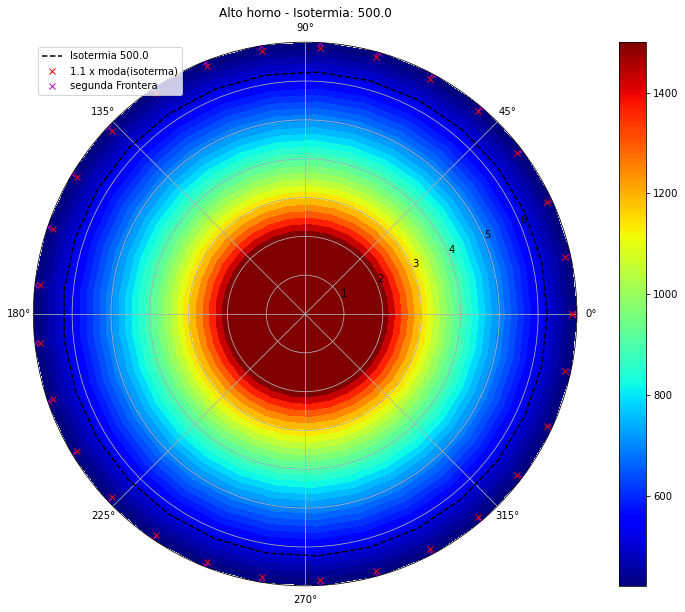

In [62]:
genInstancesNormales(ri=2, re=7, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=400.0, 
                       file='./entradas/entradaNormal.txt', 
                        internalNoise=0.1, externalNoise=0.1)
tempsNotSafeAllHot, isosNotSafeAllHot = generarGraficos(exe='../src/build/tp1',file_in='./entradas/entradaNormal.txt',
                                      file_out='./salidas/salidaNormal.txt', method='1')

<ipython-input-45-ae2d1942a597>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  grafico = ax.pcolor(thetar, r, z, cmap='jet')


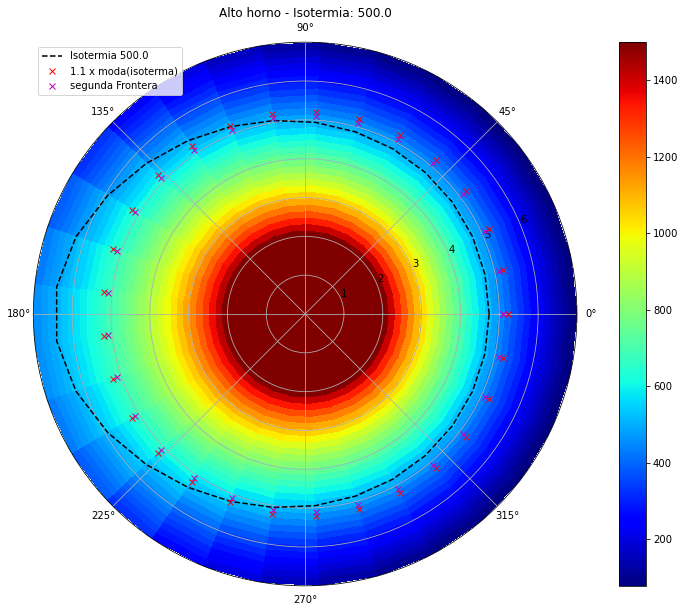

In [49]:
genInstancesPeligrosas(ri=2, re=7, m=30, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entradaPeligrosa.txt', 
                        internalNoise=0.1, externalNoise=0.1, multDeformacion=1000)
tempsNotSafe, isosNotSafe = generarGraficos(file_in='./entradas/entradaPeligrosa.txt', 
                                                      file_out='./salidas/salidaPeligrosa.txt', method='1')

In [37]:
print(tempsNotSafe[0,0])

[1500.07 1499.83 1499.99 1499.97 1499.99 1499.75 1500.04 1500.07 1500.
 1499.97 1499.9  1500.07 1500.12 1499.99 1499.91 1499.94 1500.04 1500.06
 1500.2  1500.06 1500.04 1500.1  1499.9  1500.08 1500.02 1500.09 1499.98
 1500.18 1500.05 1499.9 ]


In [9]:
def getIsothermNoSystem(file_in='./entradas/entrada1.txt'):
    
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = re-ri
    
    isos = num.empty(n)
    
    temps = num.matrix(lines[1]).reshape((2, n))
    
   
    for i in range(0, n):
            
        isos[i] = ri + delta_r * (iso - temps[1,i])/(temps[0,i] - temps[1,i])
            
    return temps, isos

In [63]:
genInstancesNormales(ri=2, re=3, m=500, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, 
                       file='./entradas/entradaPrecisa.txt', 
                        internalNoise=0.1, externalNoise=0.1)
tempsPreciso, isosPreciso = generarGraficos(exe='../src/build/tp1',file_in='./entradas/entradaPrecisa.txt',
                                      file_out='./salidas/salidaPrecisa.txt', method='1')

OSError: ./salidas/salidaPrecisa.txt not found.

In [518]:
tempsLineal, isosLineal = getIsothermNoSystem(file_in='./entradas/entradaNormal.txt')
print(num.abs(isosSafe - isosLineal))
print(isosSafe)
print(isosLineal)

[[1.17665531 1.1771881  1.17592947 1.17672825 1.1769437  1.17746465
  1.1771413  1.17696352 1.17657694 1.17690553 1.17721305 1.17674864
  1.17645832 1.17718304 1.17705229 1.17694783 1.17745744 1.17696404
  1.17724883 1.17697959 1.17742794 1.17739419 1.17692529 1.1766408
  1.17680865 1.17647855 1.17757017 1.17712942 1.17676253 1.17655553]]
[[4.72854949 4.72856026 4.72850859 4.72856774 4.72864524 4.72872982
  4.72873462 4.72867933 4.72863642 4.72863918 4.72865656 4.72861545
  4.72860573 4.72868243 4.72872411 4.72874926 4.72878203 4.72875595
  4.72876845 4.72878935 4.72883335 4.72880908 4.72869342 4.72862298
  4.72861008 4.72863552 4.72871994 4.72869541 4.72861152 4.72854599]]
[3.55189418 3.55137215 3.55257913 3.55183949 3.55170155 3.55126516
 3.55159332 3.55171581 3.55205948 3.55173365 3.55144351 3.55186682
 3.55214741 3.55149939 3.55167182 3.55180143 3.55132458 3.55179191
 3.55151962 3.55180976 3.55140541 3.55141489 3.55176813 3.55198218
 3.55180143 3.55215697 3.55114977 3.55156598 3.55

In [117]:
genInstancesNormales(ri=0.5, re=0.54, m=60, n=60, iso=0.0, ninst=2, ti=-2.0, te=30.0, 
                 file="./entradas/entradaNE.txt", internalNoise=0.1, externalNoise=0.1)
correr(exe='../src/make/tp1', file_in='./entradas/entradaNE.txt',
          file_out='./salidas/salidaSNE.txt', method='1')
correr(exe='../src/make/tp1NumericErrors', file_in='./entradas/entradaNE.txt',
          file_out='./salidas/salidaNE.txt', method='1')

tempsNE, isoNE = getIsotherm(file_in= './entradas/entradaNE.txt', file_out='./salidas/salidaNE.txt', instancias = [0])
tempsSNE, isoSNE = getIsotherm(file_in= './entradas/entradaNE.txt', file_out='./salidas/salidaSNE.txt', instancias = [0])

print(tempsSNE - tempsNE)

[[[ 0.  0.  0. ...  0.  0.  0.]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [ 0.  0.  0. ...  0.  0.  0.]]]


In [10]:
def getIsothermBoundary(file_in= './entradas/entradaAntesRefinamiento.txt', 
                        file_out='./salidas/salidaAntesRefinamiento.txt', 
                        new_file_in='./entradas/entradaRefinamiento.txt',
                        new_m=30, instancias = [0]):
    
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    delta_r = (re - ri)/m
    
    #print('\nLineas en getIsothermBound\n')
    #print(lines)
    
    
    temps = num.loadtxt(file_out).reshape((ninst, m+1, n))
    #print(delta_r)

    differences = num.abs(temps[0] - iso)
    bounds = num.empty((n,2))
    isos = num.empty(n)

    for i in range(0, n):
        column = temps[0,:,i]
        diffcolumn = differences[:,i]
        closest = diffcolumn.argmin()
        border = True

        if column[closest]<iso:
            if closest > 0:
                prev = closest - 1
                pos = closest
                border = False
            else:
                prev=closest
                pos=closest
                iso_radius = ri
        else:
            if closest < m:
                prev = closest
                pos = closest + 1
                border = False
            else:
                prev=closest
                pos=closest
                iso_radius = re

        bounds[i,0] = prev
        bounds[i,1] = pos
        
        if not border:
            
            iso_radius = ri + delta_r * (prev + (iso - column[prev])/(column[pos]-column[prev]))
            
        isos[i] = iso_radius

    innerIndex = int(bounds[:,0].min())
    outerIndex = int(bounds[:,1].max())
    
    newRi = ri+innerIndex*delta_r
    newRe = ri+outerIndex*delta_r
    internalTemps = num.ravel(temps[0,innerIndex,:].flatten())
    externalTemps = num.ravel(temps[0,outerIndex,:].flatten())
    
    f = open(new_file_in,'w',encoding = 'utf-8')
    f.write("{0:.6f} {1:.6f} {2:} {3:} {4:.1f} {5:}\n".format(newRi, newRe, new_m+1, n, iso, ninst))
    f.write(' '.join(["{:.6f}".format(elem) for elem in internalTemps]))
    f.write(' ')
    f.write(' '.join(["{:.6f}".format(elem) for elem in externalTemps]))
    f.write('\n')
    f.close()
    
    return temps[0], isos
    

In [11]:
def correrConRefinamiento(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
                          file_out='./salidas/salidaRefinamiento.txt', method='1',
                          new_m=30, cantRef=3):
    f = open(file_in,'r',encoding = 'utf-8')
    lines = f.readlines()
    params = num.matrix(lines[0])
    ri = params[0,0]
    re = params[0,1]
    m = int(params[0,2]-1)
    n = int(params[0,3])
    iso = params[0,4]
    ninst = int(params[0,5])
    f.close()
    
    isos = num.empty((cantRef+1, n))
    temps = {}
    
    correr(exe, file_in, file_out, method)
    
    for ref in range(0, cantRef):
        
        
        temp, iso = getIsothermBoundary(file_in, file_out, new_file_in=file_in, new_m=new_m, instancias = [0])
        
        isos[ref] = iso
        temps[ref] = temp
        
        #if (not puedoRefinar):
        #    print("no puedo refinar \n")
        #    return temps, isos
        
        correr(exe, file_in, file_out, method)
    
    temp, iso = getIsotherm(file_in, file_out, instancias = [0])
    
    isos[cantRef] = iso
    temps[cantRef] = temp
    
    return temps, isos
    

In [435]:
genInstancesPeligrosas(ri=200, re=700, m=16, n=30,iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entradaRefinamiento.txt", 
                           internalNoise=0.1, externalNoise=0.1)


In [436]:
temps, isos = correrConRefinamiento(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
                          file_out='./salidas/salidaRefinamiento.txt', method='1',
                          new_m=16, cantRef=10)

In [437]:
cambio_relativo = num.empty(len(isos)-1)
for i in range(0, len(isos) - 1):
    preRefinamiento = isos[i]
    posRefinamiento = isos[i+1]
    
    cambio_relativo[i] = num.abs(preRefinamiento - posRefinamiento).mean()/preRefinamiento.mean()

print(cambio_relativo)
print(isos)



[0.0155642  0.00371169 0.         0.         0.         0.
 0.         0.         0.         0.01317894]
[[450.         450.         450.         450.         450.
  481.25       481.25       481.25       512.5        543.75
  575.         606.25       700.         700.         700.
  700.         700.         700.         606.25       575.
  543.75       512.5        481.25       481.25       481.25
  450.         450.         450.         450.         450.        ]
 [465.625      465.625      465.625      465.625      465.625
  481.25       481.25       496.875      512.5        543.75
  575.         637.5        700.         700.         700.
  700.         700.         700.         637.5        575.
  543.75       512.5        496.875      481.25       481.25
  465.625      465.625      465.625      465.625      465.625     ]
 [465.625      465.625      465.625      465.625      465.625
  480.2734375  480.2734375  494.921875   509.5703125  538.8671875
  582.8125     626.7578125  70

In [381]:
cambios3 = cambio_relativo


In [12]:
def correrRefinamientoVariosM(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
                          file_out='./salidas/salidaRefinamiento.txt', method='1',
                          ms=[3, 6, 12, 30], n=30, cantRef=20):
    
    cambios_relativos = num.zeros((len(ms), cantRef))
    isos = num.zeros((len(ms), cantRef+1, n))
    
    shutil.copyfile(file_in, file_in.replace('.txt','Backup.txt'))
    tempsDict = {}
    
    
    for m in ms:
       
        f = open(file_in.replace('.txt','Backup.txt'),'r',encoding = 'utf-8')
        lines = f.readlines()
        f.close()
        params = num.matrix(lines[0])
        lines[0] = "{0:.1f} {1:.1f} {2:.0f} {3:.0f} {4:.1f} {5:.0f}\n".format(params[0,0],
                                                                              params[0,1],
                                                                              m+1,params[0,3],
                                                                              params[0,4],
                                                                              params[0,5])
        f = open(file_in, 'w',encoding = 'utf-8')
        for line in lines:
            f.writelines(line)
        f.close()
        
        #f = open('./entradas/entradaRefinamiento.txt', 'r',encoding = 'utf-8')
        #print('\nLineas en corrervariosm\n')
        #print(f.readlines())
        #f.close()
        
        
        temps, isosM = correrConRefinamiento(exe='../src/make/tp1', file_in=file_in,
                          file_out=file_out, method=method,
                          new_m=m, cantRef=cantRef)
        
        cambio_relativo = num.empty(cantRef)
        for i in range(0, cantRef):
            preRefinamiento = isosM[i]
            posRefinamiento = isosM[i+1]

            cambio_relativo[i] = num.abs(preRefinamiento - posRefinamiento).mean()/preRefinamiento.mean()
        
        cambios_relativos[ms.index(m)] = cambio_relativo
        isos[ms.index(m)] = isosM
        tempsDict[ms.index(m)] = temps
        
    
    return cambios_relativos, isos, tempsDict
        
    

In [470]:
genInstancesNormales(ri=200, re=700, m=6, n=30, iso=500.0, ninst=1, ti=1500.0, te=50.0, file="./entradas/entradaRefinamiento.txt", 
                           internalNoise=0.1, externalNoise=0.1)


In [471]:
cambios, isos, temps = correrRefinamientoVariosM(exe='../src/make/tp1', file_in='./entradas/entradaRefinamiento.txt',
                          file_out='./salidas/salidaRefinamiento.txt', method='1',
                          ms=[3, 6, 12, 24], n=30, cantRef=10)

In [472]:
print(isos)

[[[465.81760478 465.81478613 465.8062559  ... 465.8068684  465.80864607
   465.8184365 ]
  [458.56353757 458.56030194 458.5525946  ... 458.55528357 458.55706235
   458.56336407]
  [457.79404109 457.79077011 457.78315312 ... 457.78606722 457.78783547
   457.79378255]
  ...
  [457.76595204 457.76262278 457.75487573 ... 457.75784937 457.75964782
   457.76568573]
  [457.76595175 457.76262256 457.75487567 ... 457.75784895 457.75964785
   457.76568536]
  [457.76595175 457.76262256 457.75487567 ... 457.75784895 457.75964785
   457.76568536]]

 [[466.91072622 466.90708582 466.89797005 ... 466.90021076 466.90211261
   466.90961228]
  [465.79387509 465.7903478  465.78182553 ... 465.78434364 465.78620849
   465.79273274]
  [465.77053123 465.76704687 465.75863293 ... 465.7611276  465.76296946
   465.76940215]
  ...
  [465.76965497 465.7661652  465.75773794 ... 465.76023694 465.76208188
   465.7685236 ]
  [465.76965497 465.7661652  465.75773794 ... 465.76023694 465.76208188
   465.7685236 ]
  [465.

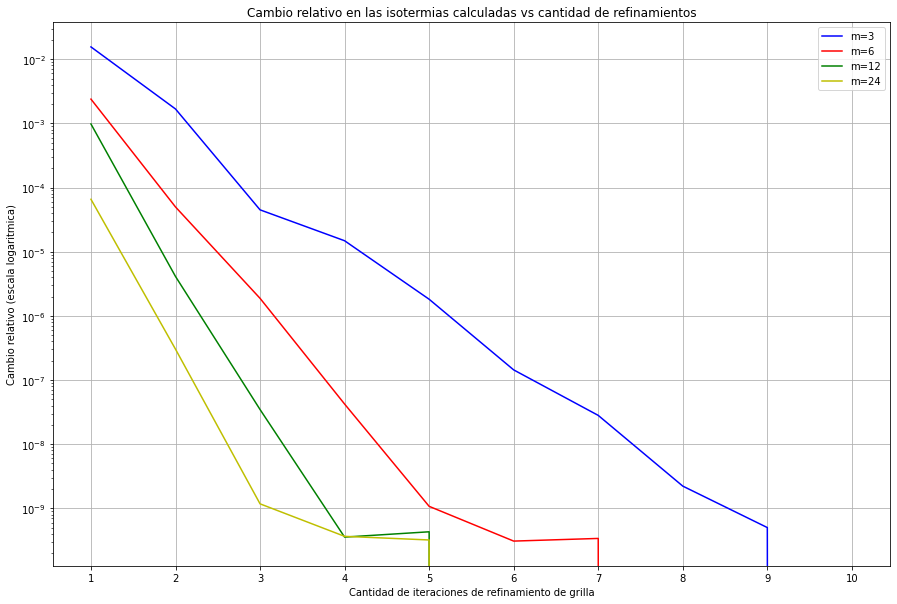

In [473]:

fig, (ax1) = plt.subplots(1, 1)
fig.set_figwidth(15)
fig.set_figheight(10)
ax1.plot(range(1,11), cambios[0], c='b', label='m=3')
ax1.plot(range(1,11), cambios[1], c='r', label='m=6')
ax1.plot(range(1,11), cambios[2], c='g', label='m=12')
ax1.plot(range(1,11), cambios[3], c='y', label='m=24')
ax1.set_yscale('log')
ax1.set_title('Cambio relativo en las isotermias calculadas vs cantidad de refinamientos')
ax1.set_ylabel('Cambio relativo (escala logaritmica)')
ax1.set_xlabel('Cantidad de iteraciones de refinamiento de grilla')
ax1.set_xticks(range(1,11,1))
ax1.grid(visible=True)
ax1.legend()


In [425]:
distancia_aOptimo= num.empty(10)

for i in range(0, 10):
    preRefinamiento = isos[3,i]
    

    distancia_aOptimo[i] = num.abs(preRefinamiento - isos[-1,-1]).mean()/preRefinamiento.mean()
        
print(distancia_aOptimo)

[6.55230555e-05 3.14529742e-07 1.18832912e-09 4.27656394e-10
 2.81022214e-10 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


### Generacion de casos para evaluar la performance en tiempo de los métodos EG vs LU.

In [531]:
# def generateTestFileForEGvsLU():
#     ninst = 1
#     for n in range(10, 50):
#         for m in range(10, 50):
#             archivo='./testEGvsLU/input/file_n' + str(n) + '_m' + str(m) + '_ninst' + str(ninst) + '.in'
#             genInstancesNormales(ri=4, re=6, m=m, n=n, iso=500, ninst=ninst, ti=1500.0, te=50.0, externalNoise=5.0, file=archivo )

def generateTestFileForEGvsLU(directory, min_n = 10, max_n = 50, min_m = 10, max_m = 50, min_ninst = 1, max_ninst = 1):
    if not os.path.exists(directory):
        os.mkdir(directory)

    for n in range(min_n, max_n+1):
        for m in range(min_m, max_m+1):
            for ninst in range(min_ninst+9, max_ninst+4, 10):
                archivo= directory + 'file_n' + str(n) + '_m' + str(m) + '_ninst' + str(ninst) + '.in'
                genInstancesNormales(ri=4, re=6, m=m, n=n, iso=500, ninst=ninst, ti=1500.0, te=50.0, externalNoise=5.0, file=archivo )

In [532]:
# generateTestFileForEGvsLU('./testEGvsLU/input/')
# test 2
generateTestFileForEGvsLU('./testEGvsLU/input2/', min_n=16, max_n=16, min_m=8, max_m=8, min_ninst=1, max_ninst=500)
# test 3
generateTestFileForEGvsLU('./testEGvsLU/input3/', min_n=16, max_n=16, min_m=16, max_m=16, min_ninst=1, max_ninst=500)
# test 4
generateTestFileForEGvsLU('./testEGvsLU/input4/', min_n=32, max_n=32, min_m=16, max_m=16, min_ninst=1, max_ninst=200)
# test 5
generateTestFileForEGvsLU('./testEGvsLU/input5/', min_n=32, max_n=32, min_m=32, max_m=32, min_ninst=1, max_ninst=200)

### Benchmarks

In [83]:
import subprocess as sp
import os
import json
from datetime import datetime

now = datetime.now()
currentTime = now.strftime("%Y%m%d_%H%M%S")

pathToExe = "../../build/Release/BenchmarkEGvsLU.exe"
repeat = 10

inputFilesDir = './testEGvsLU/input/'
results = []

for filename in os.listdir(inputFilesDir):
    input_file = os.path.join(inputFilesDir, filename)
    if os.path.isfile(input_file) and input_file.endswith(".in"):
        process = sp.Popen([pathToExe, input_file, str(repeat)], stdout=sp.PIPE)
        (output, err) = process.communicate()
        exitCode = process.wait()
        resultStr = output.decode('utf-8')
        results.append(json.loads(resultStr))

outputFilename = './testEGvsLU/results_{:}.json'.format(currentTime)
with open(outputFilename,'w', encoding='utf-8') as outputFile:
    outputFile.write(json.dumps(results, indent=4))


